# Simulated annealing

Set up:

```
python3 -m venv .venv
source .venv/bin/activate
pip install -r requirements.txt
```

In [1]:
import copy
import math
import matplotlib.pyplot as plt
import numpy as np

from scipy import stats

## Noisy curve

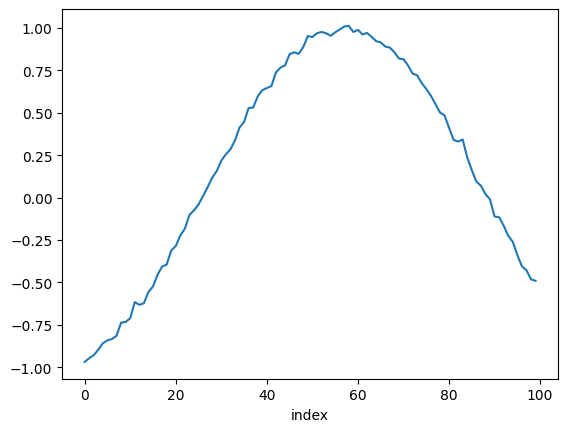

In [2]:
# Number of data points
N = 100

y = np.zeros(N)
for i in range(N):
    y[i] = math.sin(5 + i/20) + 0.2 * stats.norm.rvs(0, 0.1)

plt.plot(y)
plt.xlabel('index')
plt.show()

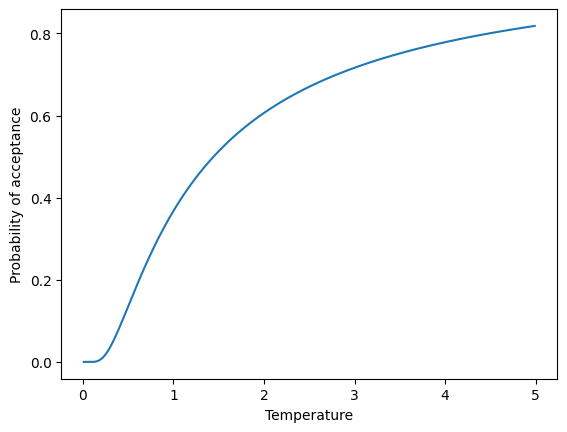

In [3]:
x = np.arange(0.01, 5, 0.01)
p_acceptance = np.exp(-1/x)
plt.plot(x, p_acceptance)
plt.xlabel('Temperature')
plt.ylabel('Probability of acceptance')
plt.show()

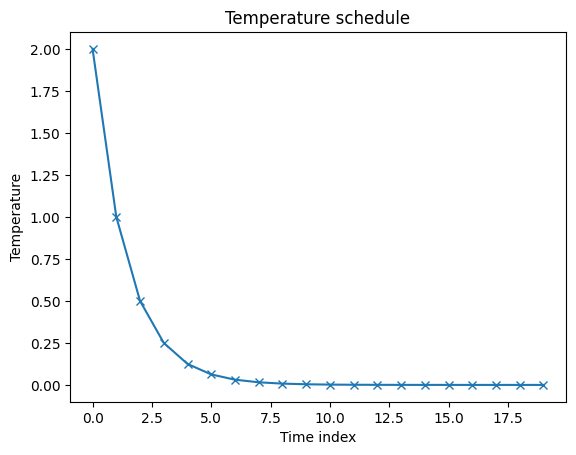

In [4]:
initial_temp = 2
rate = 0.5
temps = [initial_temp]
for i in range(1, 20):
    temps.append(temps[i-1] * rate)

plt.plot(temps, '-x')
plt.xlabel('Time index')
plt.ylabel('Temperature')
plt.title('Temperature schedule')
plt.show()

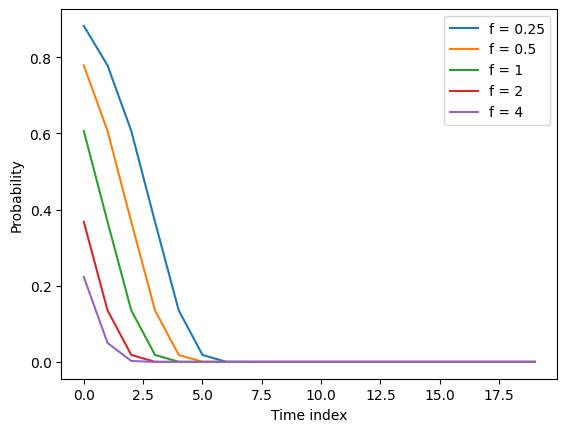

In [5]:
plt.plot([math.exp(-0.25/temp) for temp in temps], label="f = 0.25")
plt.plot([math.exp(-0.5/temp) for temp in temps], label="f = 0.5")
plt.plot([math.exp(-1/temp) for temp in temps], label="f = 1")
plt.plot([math.exp(-2/temp) for temp in temps], label="f = 2")
plt.plot([math.exp(-3/temp) for temp in temps], label="f = 4")
plt.xlabel("Time index")
plt.ylabel("Probability")
plt.legend()
plt.show()

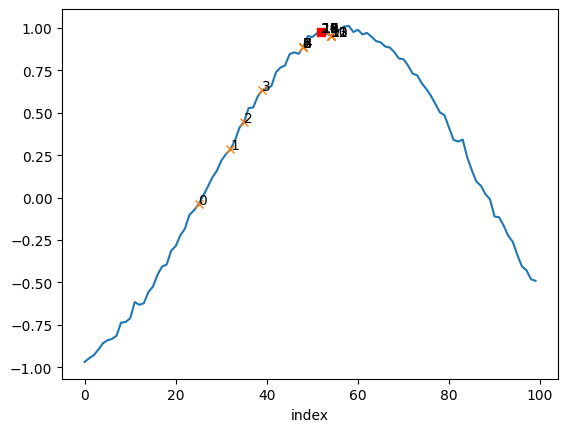

In [6]:
# Initial temperature
temp = 2

# Initial estimate of the best index
x = int(N/4)
e_best = y[x]

history_x = [x]
history_y = [e_best]

for i in range(20):
    temp = temp * 0.5
    x_candidate = x + np.random.randint(-10, 10)

    # Ensure the candidate value is in the range [0, N-1] 
    x_candidate = min(max(0, x_candidate), N-1)

    e_candidate = y[x_candidate]
    delta_f = e_candidate - e_best
    if delta_f > 0 or np.random.uniform() <= math.exp(delta_f/temp):
        x = x_candidate
        e_best = e_candidate

    history_x.append(x)
    history_y.append(e_best)

plt.plot(y)
plt.plot(history_x, history_y, 'x')
for i in range(len(history_x)):
    plt.text(history_x[i], history_y[i], f'{i}')
plt.plot(x, e_best, 'rs')
plt.xlabel('index')
plt.show()

## Generate points where the pairwise distances fit a given distribution

### Greedy optimisation using random perturbation

In [7]:
def randomly_distribute_points(max_rows, max_cols, N):

    # Define the grid
    grid = np.zeros((max_rows, max_cols))

    # Randomly place N points in the grid
    for i in range(N):
        placed = False
        while not placed:
            row = np.random.randint(max_rows)
            col = np.random.randint(max_cols)
            if grid[row, col] == 0:
                grid[row, col] = 1
                placed = True

    return grid

In [8]:
def distance(p1, p2):
    """Euclidean distance between points p1 and p2."""

    return math.sqrt(math.pow(p2[0] - p1[0], 2) + math.pow(p2[1] - p1[1], 2))

In [9]:
def positions(grid, index):
    """Find the positions of the points with the required index."""
    n_rows, n_cols = grid.shape
    positions = []
    for row in range(n_rows):
        for col in range(n_cols):
            if grid[row, col] == index:
                positions.append((row, col))    

    return positions

In [10]:
def calculate_pairwise_distances(grid, index):
    """Returns an array of the pairwise distances of elements in the grid."""

    pos = positions(grid, index)
    
    # Calculate the pairwise distances 
    distances = []
    for start in range(0, len(pos)-1):
        for end in range(start+1, len(pos)):
            distances.append(distance(pos[start], pos[end]))

    return np.array(distances)

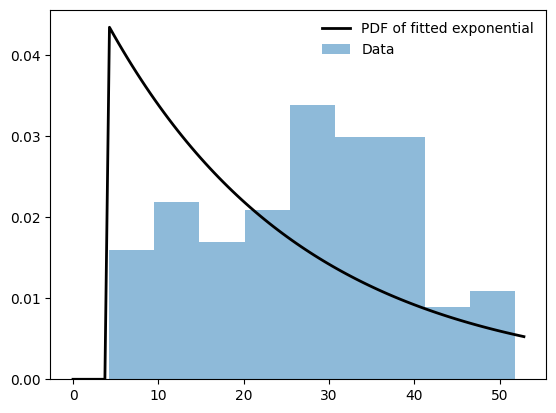

In [11]:
N = 20
max_rows = 50
max_cols = 50
grid = randomly_distribute_points(max_rows, max_cols, N)

d = calculate_pairwise_distances(grid, 1)

# Fit an exponential distribution
loc, scale = stats.expon.fit(d)

fig, ax = plt.subplots(1, 1)

x = np.linspace(0, max(d)+1, 100)
rv = stats.expon(loc, scale)
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='PDF of fitted exponential')

ax.hist(d, density=True, bins='auto', histtype='stepfilled', alpha=0.5, label='Data')
ax.legend(loc='best', frameon=False)
plt.show()

In [12]:
def randomly_move_point(grid, point, max_distance):
    n_rows, n_cols = grid.shape
    index = grid[point[0], point[1]]
    cloned_grid = grid[:]

    min_row = max(0, point[0]-max_distance)
    max_row = min(n_rows-1, point[0]+max_distance)
    min_col = max(0, point[1]-max_distance)
    max_col = min(n_cols-1, point[1]+max_distance)

    potentials = []
    for row in range(min_row, max_row+1):
        for col in range(min_col, max_col+1):
            if grid[row, col] == 0:
                potentials.append((row, col))

    if len(potentials) == 0:
        return grid
    
    r,c = potentials[np.random.randint(0, len(potentials))]
    cloned_grid[r,c] = index
    cloned_grid[point[0], point[1]] = 0

    return cloned_grid

In [13]:
current_pvalue = stats.kstest(d, stats.expon(loc, scale).cdf).pvalue

for i in range(5000):
    pos = positions(grid, index=1)
    point = pos[np.random.randint(len(pos))]
    candidate = randomly_move_point(grid, point, 1)

    # Fit an exponential distribution
    new_distances = calculate_pairwise_distances(candidate, 1)
    loc, scale = stats.expon.fit(new_distances)
    new_pvalue = stats.kstest(new_distances, stats.expon(loc, scale).cdf).pvalue        

    if new_pvalue > current_pvalue:
        grid = candidate
        current_pvalue = new_pvalue

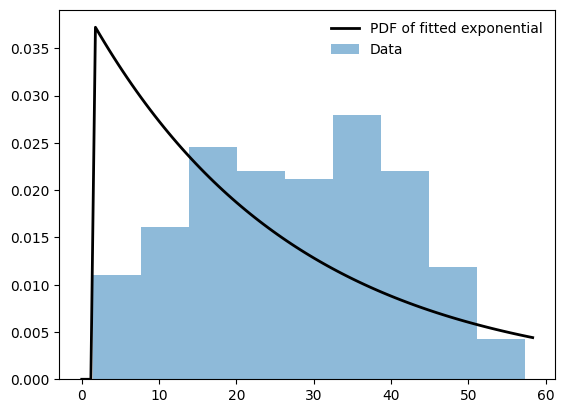

In [14]:
d = calculate_pairwise_distances(grid, 1)

# Fit an exponential distribution
loc, scale = stats.expon.fit(d)

fig, ax = plt.subplots(1, 1)

x = np.linspace(0, max(d)+1, 100)
rv = stats.expon(loc, scale)
ax.plot(x, rv.pdf(x), 'k-', lw=2, label='PDF of fitted exponential')

ax.hist(d, density=True, bins='auto', histtype='stepfilled', alpha=0.5, label='Data')
ax.legend(loc='best', frameon=False)
plt.show()

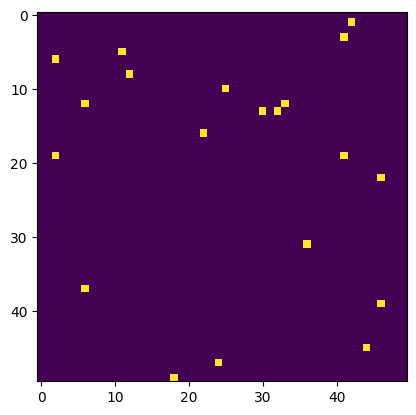

In [15]:
plt.imshow(grid)
plt.show()

### Simulated annealing

In [16]:
def is_point_occupied(points, row, col):
    for p_row, p_col in points:
        if p_row == row and p_col == col:
            return True
    
    return False

In [17]:
def move_point(points, point_idx, n_rows, n_cols, max_distance):
    initial_position = points[point_idx]

    min_row = max(0, initial_position[0] - max_distance)
    max_row = min(n_rows-1, initial_position[0] + max_distance)

    min_col = max(0, initial_position[1] - max_distance)
    max_col = min(n_cols-1, initial_position[1] + max_distance)

    candidates = []
    for row in range(min_row, max_row+1):
        for col in range(min_col, max_col+1):
            if not is_point_occupied(points, row, col):
                candidates.append((row, col))

    if len(candidates) == 0:
        return initial_position

    return candidates[np.random.randint(0, len(candidates))]

In [18]:
def convert_points_to_grid(points, max_rows, max_cols):

    grid = np.zeros((max_rows, max_cols))
    for point in points:
        grid[point[0], point[1]] = 1
    
    return grid

In [19]:
def calc_distance(points: list[tuple[int, int]]):

    # Calculate the pairwise distances between points
    distances = []
    for i in range(len(points)-1):
        for j in range(1, len(points)):
            d = math.sqrt(math.pow(points[i][0] - points[j][0], 2) + math.pow(points[i][1] - points[j][1], 2))
            distances.append(d)

    # Fit an exponential distribution to the points
    loc, scale = stats.expon.fit(distances)

    # Determine the x-values for the distributions
    x_max = int(max(distances)) + 1
    bins = range(x_max)

    # Calculate the expected and actual mass in each bin
    actual_mass = []
    expected_mass = []
    for i in range(len(bins)-1):
        bin_lower = bins[i]
        bin_upper = bins[i+1]

        actual_mass.append(len([d for d in distances if d >= bin_lower and d < bin_upper]))
        expected_mass.append(stats.expon(loc, scale).cdf(bin_upper) - stats.expon(loc, scale).cdf(bin_lower))

    # Normalise the masses
    actual_mass = np.array(actual_mass)
    expected_mass = np.array(expected_mass)

    actual_mass = actual_mass / actual_mass.sum()
    expected_mass = expected_mass / expected_mass.sum()

    return stats.wasserstein_distance(actual_mass, expected_mass)

In [20]:
def move_points_to_fit_exponential_dist(grid, 
                                        n_rows,
                                        n_cols,
                                        temp=1, 
                                        n_steps=10,
                                        cooling_rate=0.95,
                                        max_distance = 5):

    # Make a copy of the data so as not to mutate the grid
    grid = copy.deepcopy(grid)

    # Create a sparse representation of the points
    points = positions(grid, 1)

    for step_idx in range(n_steps):

        if step_idx > 0:
            temp = initial_temp
        else:
            temp = temp * cooling_rate

        for point_idx in range(len(points)):
 
            candidate_points = points[:]
            candidate_points[point_idx] = move_point(points, point_idx, n_rows, n_cols, max_distance)

            delta_f = calc_distance(candidate_points) - calc_distance(points)
            
            if delta_f < 0 or np.random.uniform() <= math.exp(-delta_f/temp):
                points = candidate_points

    return convert_points_to_grid(points, n_rows, n_cols)

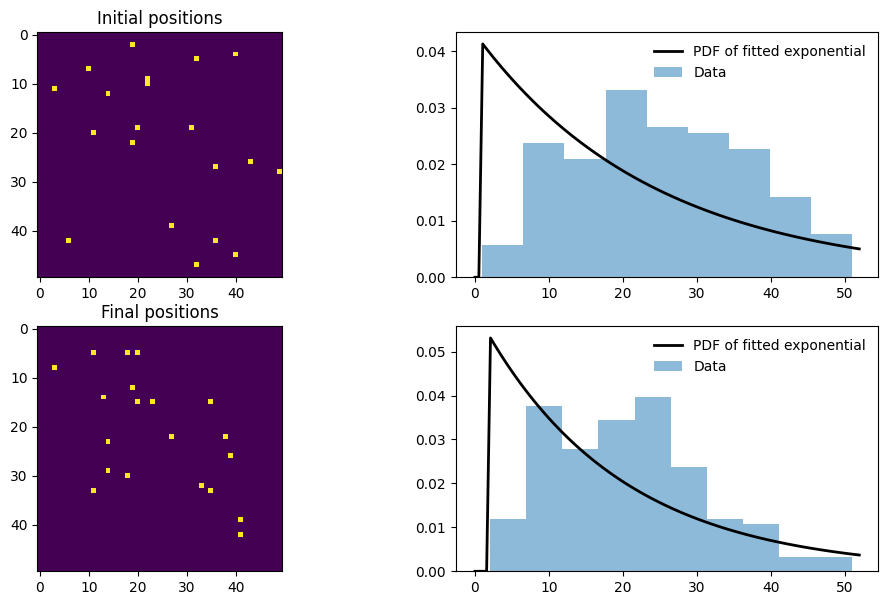

In [21]:
N = 20
max_rows = 50
max_cols = 50
initial_positions = randomly_distribute_points(max_rows, max_cols, N)

# Fit an exponential distribution to the initial position distances
initial_d = calculate_pairwise_distances(initial_positions, 1)
loc, scale = stats.expon.fit(initial_d)

# Use simulated annealing to try to move the points to fit an exponential distribution
final_positions = move_points_to_fit_exponential_dist(grid=initial_positions, 
                                                      n_rows=max_rows, 
                                                      n_cols=max_cols,
                                                      temp=1,
                                                      n_steps=100,
                                                      cooling_rate=0.95,
                                                      max_distance=10)

# Fit an exponential distribution to the final position distances
final_d = calculate_pairwise_distances(final_positions, 1)
loc2, scale2 = stats.expon.fit(final_d)

# Create the plots
plt.figure(figsize=(12,7))
plt.subplot(2,2,1)
plt.imshow(initial_positions)
plt.title('Initial positions')

plt.subplot(2,2,2)
x = np.linspace(0, max(initial_d)+1, 100)
plt.plot(x, stats.expon(loc, scale).pdf(x), 'k-', lw=2, label='PDF of fitted exponential')
plt.hist(initial_d, density=True, bins='auto', histtype='stepfilled', alpha=0.5, label='Data')
plt.legend(loc='best', frameon=False)

plt.subplot(2,2,3)
plt.imshow(final_positions)
plt.title('Final positions')

plt.subplot(2,2,4)
x = np.linspace(0, max(final_d)+1, 100)
plt.plot(x, stats.expon(loc2, scale2).pdf(x), 'k-', lw=2, label='PDF of fitted exponential')
plt.hist(final_d, density=True, bins='auto', histtype='stepfilled', alpha=0.5, label='Data')
plt.legend(loc='best', frameon=False)

plt.show()